# Shelter Animal Outcomes
## Help improve outcomes for shelter animals

Every year, over 7.6 million animals were found in shelter (dogs and cats), despite a majority of the population find their forever homes, still many are not as lucky, and over 2.7 million animals are enthanized every year in the US. We are asking to predict the outcome for each animals from Austin Animal Center based on breed, color, sex and age informations.

-----

## Datasets
[Data link on Kaggle](https://www.kaggle.com/c/shelter-animal-outcomes)
 - train.csv 
     - data entries: 26729
     - data features: 10
 - test.csv
     - data entries: 11456
     - data features: 8

In [283]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

#tensorflow keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical

#import the scikit-learn classifiers
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

## load data

In [284]:
data=pd.read_csv('datasets/train.csv', header=0)
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [285]:
#check for data type and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB


## Data Cleaning and EDA

In [286]:
#convert the datetime into data type
data['DateTime']=pd.to_datetime(data['DateTime'])

In [287]:
#save the years of the datetime into date_year column
data['Date_year'] = pd.DatetimeIndex(data['DateTime']).year

In [288]:
#save the month of the datetime into date_month column
data['Date_month'] = pd.DatetimeIndex(data['DateTime']).month

In [289]:
#drop the datetime column
data.drop(columns=['DateTime'],inplace=True)

In [290]:
#check how many missing value in age
data['AgeuponOutcome'].isnull().sum()

18

In [291]:
#drop null value based on `AgeuponOutcome` column
data.dropna(subset=['AgeuponOutcome'], inplace=True)

In [293]:
#split the number from the unit into a list
data['AgeuponOutcome'] = data['AgeuponOutcome'].str.split(' ')

In [294]:
#check the first 5 values in the age column
data['AgeuponOutcome'][:5]

0     [1, year]
1     [1, year]
2    [2, years]
3    [3, weeks]
4    [2, years]
Name: AgeuponOutcome, dtype: object

In [295]:
#save the number and units into a dataframe
df=pd.DataFrame(data['AgeuponOutcome'].to_list(), columns=['num', 'units'], index=data.index)

In [296]:
#understand what units are included in AgeuponOutcome
df['units'].value_counts(normalize=True)

years     0.407098
months    0.312193
year      0.148590
weeks     0.063794
month     0.047958
days      0.012429
week      0.005466
day       0.002471
Name: units, dtype: float64

In [297]:
#Add the splitted columns to the original data frame
data=pd.concat([data, df], axis=1)

#drop the original AgeuponOutcome column
data.drop(columns=['AgeuponOutcome'], inplace=True)

In [298]:
#convert the 'num' datatype into integer
data['num'] = data['num'].astype(int)

data.reset_index(inplace=True)

#get a list of age in weeks based on units of age

#initialize an empty list
age=[]

#loop through the dataframe
for i in range(len(data)):
    # if the age units is in year or years, times 52.143 to convert the num in years into weeks
    if data['units'][i] in ['year','years']:
        age.append(data['num'][i]*52.143 )
    # if the age units is in month or months, times 4.345 to convert the num in months into weeks
    elif data['units'][i] in ['month','months']:
        age.append(data['num'][i]*4.345 )
    # if the age units is in day or days, times .143 to convert the num in days into weeks
    elif data['units'][i] in ['day','days']:
        age.append(data['num'][i]*.143)
    #else, just append the original
    else:
        age.append(data['num'][i])

#create a column of age in weeks
data['age_in_weeks']=age

#drop the num and units columns
data.drop(columns=['num','units'], inplace=True)

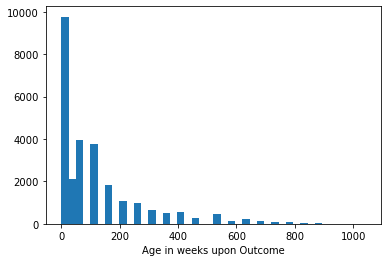

In [368]:
#verify the values of age in weeks, check for any outlier points
data['age_in_weeks'].hist(bins=42, grid=False)
plt.xlabel('Age in weeks upon Outcome');

#### Observation: most of the animals upon outcome is very young, less than 50 weeks!

In [300]:
#get the column names
data.columns

Index(['index', 'AnimalID', 'Name', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'Breed', 'Color', 'Date_year',
       'Date_month', 'age_in_weeks'],
      dtype='object')

In [301]:
#convert categorical columns to numeric by get_dummies
data =pd.get_dummies(data, columns=['SexuponOutcome','Breed','Color','AnimalType'], drop_first=True)

#check first 5 rows
data.head()

,index,AnimalID,Name,OutcomeType,OutcomeSubtype,Date_year,Date_month,age_in_weeks,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,...,Color_White/Yellow Brindle,Color_Yellow,Color_Yellow Brindle,Color_Yellow Brindle/Blue,Color_Yellow Brindle/Tan,Color_Yellow Brindle/White,Color_Yellow/Black,Color_Yellow/White,Color_Yellow/Yellow,AnimalType_Dog
0,0,A671945,Hambone,Return_to_owner,NaN,2014,2,52.143,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,A656520,Emily,Euthanasia,Suffering,2013,10,52.143,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,A686464,Pearce,Adoption,Foster,2015,1,104.286,0,1,...,0,0,0,0,0,0,0,0,0,1
3,3,A683430,NaN,Transfer,Partner,2014,7,3.000,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,A667013,NaN,Transfer,Partner,2013,11,104.286,0,1,...,0,0,0,0,0,0,0,0,0,1


### Notice that the 5 classes are unbalanced, the model might not be able to accurately predict `Ethanasia` and `Died` due to a very low probability

In [302]:
#check the types of outcome
data['OutcomeType'].value_counts(normalize=True)

Adoption           0.403167
Transfer           0.352140
Return_to_owner    0.179177
Euthanasia         0.058141
Died               0.007375
Name: OutcomeType, dtype: float64

### Convert the target variable to numeric columns

In [303]:
#create a dictionary for mapping the categorical values into numeric
dict={'Adoption':0, 'Transfer':1, 'Return_to_owner':2, 'Euthanasia':3, 'Died':4}
data['OutcomeType'] = data['OutcomeType'].map(dict)

## Create X features and target variable y

In [304]:
features=['Date_year',
 'Date_month',
 'age_in_weeks',
 'SexuponOutcome_Intact Male',
 'SexuponOutcome_Neutered Male',
 'SexuponOutcome_Spayed Female',
 'SexuponOutcome_Unknown',
 'Breed_Airedale Terrier Mix',
 'Breed_Akita',
 'Breed_Akita Mix',
 'Breed_Akita/German Shepherd',
 'Breed_Alaskan Husky',
 'Breed_Alaskan Husky Mix',
 'Breed_Alaskan Malamute',
 'Breed_Alaskan Malamute Mix',
 'Breed_Alaskan Malamute/German Shepherd',
 'Breed_American Bulldog',
 'Breed_American Bulldog Mix',
 'Breed_American Bulldog/Pit Bull',
 'Breed_American Eskimo Mix',
 'Breed_American Foxhound Mix',
 'Breed_American Pit Bull Terrier',
 'Breed_American Pit Bull Terrier Mix',
 'Breed_American Shorthair Mix',
 'Breed_American Staffordshire Terrier',
 'Breed_American Staffordshire Terrier Mix',
 'Breed_American Staffordshire Terrier/American Bulldog',
 'Breed_Anatol Shepherd',
 'Breed_Anatol Shepherd Mix',
 'Breed_Anatol Shepherd/German Shepherd',
 'Breed_Anatol Shepherd/Great Pyrenees',
 'Breed_Anatol Shepherd/Labrador Retriever',
 'Breed_Angora Mix',
 'Breed_Australian Cattle Dog',
 'Breed_Australian Cattle Dog Mix',
 'Breed_Australian Cattle Dog/Australian Shepherd',
 'Breed_Australian Cattle Dog/Basenji',
 'Breed_Australian Cattle Dog/Beagle',
 'Breed_Australian Cattle Dog/Catahoula',
 'Breed_Australian Cattle Dog/Chinese Sharpei',
 'Breed_Australian Cattle Dog/Dachshund',
 'Breed_Australian Cattle Dog/German Shepherd',
 'Breed_Australian Cattle Dog/German Shorthair Pointer',
 'Breed_Australian Cattle Dog/Great Pyrenees',
 'Breed_Australian Cattle Dog/Jack Russell Terrier',
 'Breed_Australian Cattle Dog/Labrador Retriever',
 'Breed_Australian Cattle Dog/Pit Bull',
 'Breed_Australian Cattle Dog/Plott Hound',
 'Breed_Australian Cattle Dog/Pointer',
 'Breed_Australian Kelpie',
 'Breed_Australian Kelpie Mix',
 'Breed_Australian Kelpie/Blue Lacy',
 'Breed_Australian Kelpie/Labrador Retriever',
 'Breed_Australian Shepherd',
 'Breed_Australian Shepherd Mix',
 'Breed_Australian Shepherd/Anatol Shepherd',
 'Breed_Australian Shepherd/Border Collie',
 'Breed_Australian Shepherd/Boxer',
 'Breed_Australian Shepherd/Chihuahua Shorthair',
 'Breed_Australian Shepherd/Cocker Spaniel',
 'Breed_Australian Shepherd/Labrador Retriever',
 'Breed_Australian Shepherd/Plott Hound',
 'Breed_Australian Shepherd/Rottweiler',
 'Breed_Australian Terrier Mix',
 'Breed_Balinese Mix',
 'Breed_Basenji Mix',
 'Breed_Basenji/Australian Cattle Dog',
 'Breed_Basenji/Chihuahua Shorthair',
 'Breed_Basenji/Chow Chow',
 'Breed_Basset Hound',
 'Breed_Basset Hound Mix',
 'Breed_Basset Hound/Australian Cattle Dog',
 'Breed_Basset Hound/Beagle',
 'Breed_Basset Hound/Labrador Retriever',
 'Breed_Beagle',
 'Breed_Beagle Mix',
 'Breed_Beagle/Australian Cattle Dog',
 'Breed_Beagle/Boxer',
 'Breed_Beagle/Chihuahua Shorthair',
 'Breed_Beagle/Cocker Spaniel',
 'Breed_Beagle/Dachshund',
 'Breed_Beagle/German Shepherd',
 'Breed_Beagle/Jack Russell Terrier',
 'Breed_Beagle/Labrador Retriever',
 'Breed_Beagle/Pit Bull',
 'Breed_Beagle/Pug',
 'Breed_Beagle/Rat Terrier',
 'Breed_Bearded Collie Mix',
 'Breed_Beauceron',
 'Breed_Beauceron Mix',
 'Breed_Belgian Malinois',
 'Breed_Belgian Malinois Mix',
 'Breed_Belgian Tervuren Mix',
 'Breed_Bengal Mix',
 'Breed_Bernese Mountain Dog',
 'Breed_Bichon Frise',
 'Breed_Bichon Frise Mix',
 'Breed_Black Mouth Cur',
 'Breed_Black Mouth Cur Mix',
 'Breed_Black Mouth Cur/Blue Lacy',
 'Breed_Black Mouth Cur/Boxer',
 'Breed_Black Mouth Cur/Catahoula',
 'Breed_Black/Tan Hound',
 'Breed_Black/Tan Hound Mix',
 'Breed_Bloodhound',
 'Breed_Blue Lacy',
 'Breed_Blue Lacy Mix',
 'Breed_Bluetick Hound Mix',
 'Breed_Boerboel Mix',
 'Breed_Bombay Mix',
 'Breed_Border Collie',
 'Breed_Border Collie Mix',
 'Breed_Border Collie/Australian Cattle Dog',
 'Breed_Border Collie/Beagle',
 'Breed_Border Collie/German Shepherd',
 'Breed_Border Collie/Great Pyrenees',
 'Breed_Border Collie/Labrador Retriever',
 'Breed_Border Collie/Pit Bull',
 'Breed_Border Collie/Pointer',
 'Breed_Border Terrier',
 'Breed_Border Terrier Mix',
 'Breed_Border Terrier/Chihuahua Shorthair',
 'Breed_Border Terrier/Yorkshire Terrier',
 'Breed_Boston Terrier',
 'Breed_Boston Terrier Mix',
 'Breed_Boston Terrier/Chihuahua Shorthair',
 'Breed_Boston Terrier/Dachshund',
 'Breed_Boston Terrier/Miniature Schnauzer',
 'Breed_Boston Terrier/Pug',
 'Breed_Boxer',
 'Breed_Boxer Mix',
 'Breed_Boxer/Catahoula',
 'Breed_Boxer/Great Dane',
 'Breed_Boxer/Labrador Retriever',
 'Breed_Boxer/Pit Bull',
 'Breed_Boxer/Staffordshire',
 'Breed_British Shorthair Mix',
 'Breed_Brittany',
 'Breed_Brittany Mix',
 'Breed_Bruss Griffon Mix',
 'Breed_Bull Terrier',
 'Breed_Bull Terrier Miniature',
 'Breed_Bull Terrier Miniature Mix',
 'Breed_Bull Terrier Mix',
 'Breed_Bulldog Mix',
 'Breed_Bullmastiff',
 'Breed_Bullmastiff Mix',
 'Breed_Cairn Terrier',
 'Breed_Cairn Terrier Mix',
 'Breed_Cairn Terrier/Chihuahua Longhair',
 'Breed_Cairn Terrier/Chihuahua Shorthair',
 'Breed_Cairn Terrier/Yorkshire Terrier',
 'Breed_Canaan Dog Mix',
 'Breed_Canaan Dog/Pit Bull',
 'Breed_Cane Corso',
 'Breed_Cane Corso Mix',
 'Breed_Cardigan Welsh Corgi',
 'Breed_Cardigan Welsh Corgi Mix',
 'Breed_Cardigan Welsh Corgi/Australian Cattle Dog',
 'Breed_Cardigan Welsh Corgi/Australian Shepherd',
 'Breed_Cardigan Welsh Corgi/Beagle',
 'Breed_Cardigan Welsh Corgi/Chihuahua Shorthair',
 'Breed_Cardigan Welsh Corgi/Cocker Spaniel',
 'Breed_Cardigan Welsh Corgi/German Shepherd',
 'Breed_Cardigan Welsh Corgi/Pointer',
 'Breed_Carolina Dog',
 'Breed_Carolina Dog Mix',
 'Breed_Carolina Dog/Australian Cattle Dog',
 'Breed_Carolina Dog/Chihuahua Shorthair',
 'Breed_Catahoula',
 'Breed_Catahoula Mix',
 'Breed_Catahoula/Australian Cattle Dog',
 'Breed_Catahoula/Boxer',
 'Breed_Catahoula/Cardigan Welsh Corgi',
 'Breed_Catahoula/Chinese Sharpei',
 'Breed_Catahoula/German Shepherd',
 'Breed_Catahoula/Great Dane',
 'Breed_Catahoula/Labrador Retriever',
 'Breed_Catahoula/Pit Bull',
 'Breed_Catahoula/Pointer',
 'Breed_Cavalier Span',
 'Breed_Cavalier Span Mix',
 'Breed_Chesa Bay Retr Mix',
 'Breed_Chihuahua Longhair',
 'Breed_Chihuahua Longhair Mix',
 'Breed_Chihuahua Longhair/Cairn Terrier',
 'Breed_Chihuahua Longhair/Dachshund',
 'Breed_Chihuahua Longhair/Maltese',
 'Breed_Chihuahua Longhair/Papillon',
 'Breed_Chihuahua Longhair/Pekingese',
 'Breed_Chihuahua Longhair/Pomeranian',
 'Breed_Chihuahua Shorthair',
 'Breed_Chihuahua Shorthair Mix',
 'Breed_Chihuahua Shorthair/Basset Hound',
 'Breed_Chihuahua Shorthair/Beagle',
 'Breed_Chihuahua Shorthair/Border Terrier',
 'Breed_Chihuahua Shorthair/Boston Terrier',
 'Breed_Chihuahua Shorthair/Cairn Terrier',
 'Breed_Chihuahua Shorthair/Cardigan Welsh Corgi',
 'Breed_Chihuahua Shorthair/Dachshund',
 'Breed_Chihuahua Shorthair/Dachshund Wirehair',
 'Breed_Chihuahua Shorthair/German Shepherd',
 'Breed_Chihuahua Shorthair/Italian Greyhound',
 'Breed_Chihuahua Shorthair/Jack Russell Terrier',
 'Breed_Chihuahua Shorthair/Manchester Terrier',
 'Breed_Chihuahua Shorthair/Miniature Pinscher',
 'Breed_Chihuahua Shorthair/Pembroke Welsh Corgi',
 'Breed_Chihuahua Shorthair/Pit Bull',
 'Breed_Chihuahua Shorthair/Pomeranian',
 'Breed_Chihuahua Shorthair/Pug',
 'Breed_Chihuahua Shorthair/Rat Terrier',
 'Breed_Chihuahua Shorthair/Schipperke',
 'Breed_Chihuahua Shorthair/Smooth Fox Terrier',
 'Breed_Chihuahua Shorthair/Whippet',
 'Breed_Chihuahua Shorthair/Yorkshire Terrier',
 'Breed_Chinese Crested Mix',
 'Breed_Chinese Sharpei',
 'Breed_Chinese Sharpei Mix',
 'Breed_Chinese Sharpei/Labrador Retriever',
 'Breed_Chow Chow',
 'Breed_Chow Chow Mix',
 'Breed_Chow Chow/German Shepherd',
 'Breed_Chow Chow/Golden Retriever',
 'Breed_Chow Chow/Labrador Retriever',
 'Breed_Cocker Spaniel',
 'Breed_Cocker Spaniel Mix',
 'Breed_Cocker Spaniel/Labrador Retriever',
 'Breed_Cocker Spaniel/Miniature Poodle',
 'Breed_Collie Rough',
 'Breed_Collie Rough Mix',
 'Breed_Collie Smooth',
 'Breed_Collie Smooth Mix',
 'Breed_Collie Smooth/Labrador Retriever',
 'Breed_Cymric Mix',
 'Breed_Dachshund',
 'Breed_Dachshund Longhair',
 'Breed_Dachshund Longhair Mix',
 'Breed_Dachshund Longhair/Chihuahua Longhair',
 'Breed_Dachshund Longhair/Chihuahua Shorthair',
 'Breed_Dachshund Mix',
 'Breed_Dachshund Wirehair Mix',
 'Breed_Dachshund Wirehair/Border Terrier',
 'Breed_Dachshund Wirehair/Chihuahua Shorthair',
 'Breed_Dachshund Wirehair/Miniature Poodle',
 'Breed_Dachshund Wirehair/Miniature Schnauzer',
 'Breed_Dachshund Wirehair/Toy Poodle',
 'Breed_Dachshund/Basset Hound',
 'Breed_Dachshund/Beagle',
 'Breed_Dachshund/Bloodhound',
 'Breed_Dachshund/Chihuahua Longhair',
 'Breed_Dachshund/Chihuahua Shorthair',
 'Breed_Dachshund/English Foxhound',
 'Breed_Dachshund/Labrador Retriever',
 'Breed_Dachshund/Manchester Terrier',
 'Breed_Dachshund/Miniature Poodle',
 'Breed_Dachshund/Parson Russell Terrier',
 'Breed_Dachshund/Pit Bull',
 'Breed_Dachshund/Pug',
 'Breed_Dachshund/Shih Tzu',
 'Breed_Dachshund/Yorkshire Terrier',
 'Breed_Dalmatian',
 'Breed_Dalmatian Mix',
 'Breed_Dalmatian/Labrador Retriever',
 'Breed_Devon Rex',
 'Breed_Devon Rex Mix',
 'Breed_Doberman Pinsch',
 'Breed_Doberman Pinsch Mix',
 'Breed_Doberman Pinsch/Australian Cattle Dog',
 'Breed_Doberman Pinsch/German Shepherd',
 'Breed_Dogo Argentino Mix',
 'Breed_Dogo Argentino/Labrador Retriever',
 'Breed_Dogue De Bordeaux Mix',
 'Breed_Domestic Longhair',
 'Breed_Domestic Longhair Mix',
 'Breed_Domestic Longhair/Rex',
 'Breed_Domestic Medium Hair',
 'Breed_Domestic Medium Hair Mix',
 'Breed_Domestic Shorthair',
 'Breed_Domestic Shorthair Mix',
 'Breed_Dutch Shepherd',
 'Breed_Dutch Shepherd Mix',
 'Breed_English Bulldog',
 'Breed_English Bulldog Mix',
 'Breed_English Cocker Spaniel Mix',
 'Breed_English Coonhound Mix',
 'Breed_English Foxhound Mix',
 'Breed_English Pointer Mix',
 'Breed_English Springer Spaniel',
 'Breed_English Springer Spaniel Mix',
 'Breed_Feist Mix',
 'Breed_Field Spaniel Mix',
 'Breed_Finnish Spitz Mix',
 'Breed_Flat Coat Retriever Mix',
 'Breed_Flat Coat Retriever/German Shepherd',
 'Breed_Flat Coat Retriever/Papillon',
 'Breed_Flat Coat Retriever/Pit Bull',
 'Breed_French Bulldog',
 'Breed_French Bulldog Mix',
 'Breed_German Pinscher Mix',
 'Breed_German Shepherd',
 'Breed_German Shepherd Mix',
 'Breed_German Shepherd/Akita',
 'Breed_German Shepherd/Alaskan Husky',
 'Breed_German Shepherd/Australian Cattle Dog',
 'Breed_German Shepherd/Australian Shepherd',
 'Breed_German Shepherd/Black/Tan Hound',
 'Breed_German Shepherd/Boxer',
 'Breed_German Shepherd/Cardigan Welsh Corgi',
 'Breed_German Shepherd/Catahoula',
 'Breed_German Shepherd/Chow Chow',
 'Breed_German Shepherd/Collie Rough',
 'Breed_German Shepherd/Doberman Pinsch',
 'Breed_German Shepherd/Golden Retriever',
 'Breed_German Shepherd/Great Dane',
 'Breed_German Shepherd/Labrador Retriever',
 'Breed_German Shepherd/Mastiff',
 'Breed_German Shepherd/Pit Bull',
 'Breed_German Shepherd/Rottweiler',
 'Breed_German Shepherd/Siberian Husky',
 'Breed_German Shorthair Pointer Mix',
 'Breed_German Wirehaired Pointer Mix',
 'Breed_Glen Of Imaal Mix',
 'Breed_Golden Retriever',
 'Breed_Golden Retriever Mix',
 'Breed_Golden Retriever/Beagle',
 'Breed_Golden Retriever/Border Collie',
 'Breed_Golden Retriever/Chow Chow',
 'Breed_Golden Retriever/Dachshund',
 'Breed_Golden Retriever/Labrador Retriever',
 'Breed_Great Dane',
 'Breed_Great Dane Mix',
 'Breed_Great Dane/Labrador Retriever',
 'Breed_Great Dane/Pit Bull',
 'Breed_Great Pyrenees',
 'Breed_Great Pyrenees Mix',
 'Breed_Great Pyrenees/Australian Cattle Dog',
 'Breed_Great Pyrenees/Australian Shepherd',
 'Breed_Great Pyrenees/Border Collie',
 'Breed_Great Pyrenees/Catahoula',
 'Breed_Great Pyrenees/Labrador Retriever',
 'Breed_Great Pyrenees/Pit Bull',
 'Breed_Great Pyrenees/Pointer',
 'Breed_Great Pyrenees/Rottweiler',
 'Breed_Great Pyrenees/Standard Poodle',
 'Breed_Greyhound',
 'Breed_Greyhound Mix',
 'Breed_Greyhound/Labrador Retriever',
 'Breed_Harrier',
 'Breed_Harrier Mix',
 'Breed_Havanese Mix',
 'Breed_Himalayan',
 'Breed_Himalayan Mix',
 'Breed_Irish Setter/Pit Bull',
 'Breed_Irish Terrier Mix',
 'Breed_Irish Terrier/Labrador Retriever',
 'Breed_Italian Greyhound Mix',
 'Breed_Italian Greyhound/Chihuahua Shorthair',
 'Breed_Jack Russell Terrier',
 'Breed_Jack Russell Terrier Mix',
 'Breed_Jack Russell Terrier/Australian Cattle Dog',
 'Breed_Jack Russell Terrier/Beagle',
 'Breed_Jack Russell Terrier/Border Collie',
 'Breed_Jack Russell Terrier/Chihuahua Shorthair',
 'Breed_Jack Russell Terrier/Dachshund',
 'Breed_Jack Russell Terrier/Dachshund Wirehair',
 'Breed_Jack Russell Terrier/Labrador Retriever',
 'Breed_Jack Russell Terrier/Miniature Poodle',
 'Breed_Jack Russell Terrier/Rat Terrier',
 'Breed_Jack Russell Terrier/Welsh Terrier',
 'Breed_Japanese Chin Mix',
 'Breed_Keeshond Mix',
 'Breed_Labrador Retriever',
 'Breed_Labrador Retriever Mix',
 'Breed_Labrador Retriever/American Pit Bull Terrier',
 'Breed_Labrador Retriever/Anatol Shepherd',
 'Breed_Labrador Retriever/Australian Cattle Dog',
 'Breed_Labrador Retriever/Australian Kelpie',
 'Breed_Labrador Retriever/Australian Shepherd',
 'Breed_Labrador Retriever/Basset Hound',
 'Breed_Labrador Retriever/Beagle',
 'Breed_Labrador Retriever/Black/Tan Hound',
 'Breed_Labrador Retriever/Blue Lacy',
 'Breed_Labrador Retriever/Border Collie',
 'Breed_Labrador Retriever/Boxer',
 'Breed_Labrador Retriever/Catahoula',
 'Breed_Labrador Retriever/Chinese Sharpei',
 'Breed_Labrador Retriever/Chow Chow',
 'Breed_Labrador Retriever/Collie Smooth',
 'Breed_Labrador Retriever/Dachshund',
 'Breed_Labrador Retriever/Dalmatian',
 'Breed_Labrador Retriever/Doberman Pinsch',
 'Breed_Labrador Retriever/Flat Coat Retriever',
 'Breed_Labrador Retriever/German Shepherd',
 'Breed_Labrador Retriever/Golden Retriever',
 'Breed_Labrador Retriever/Great Pyrenees',
 'Breed_Labrador Retriever/Greyhound',
 'Breed_Labrador Retriever/Jack Russell Terrier',
 'Breed_Labrador Retriever/Labrador Retriever',
 'Breed_Labrador Retriever/Mastiff',
 'Breed_Labrador Retriever/Miniature Poodle',
 'Breed_Labrador Retriever/Pit Bull',
 'Breed_Labrador Retriever/Plott Hound',
 'Breed_Labrador Retriever/Pointer',
 'Breed_Labrador Retriever/Queensland Heeler',
 'Breed_Labrador Retriever/Redbone Hound',
 'Breed_Labrador Retriever/Rottweiler',
 'Breed_Labrador Retriever/Siberian Husky',
 'Breed_Labrador Retriever/Standard Poodle',
 'Breed_Labrador Retriever/Standard Schnauzer',
 'Breed_Labrador Retriever/Vizsla',
 'Breed_Leonberger Mix',
 'Breed_Lhasa Apso',
 'Breed_Lhasa Apso Mix',
 'Breed_Lhasa Apso/Cairn Terrier',
 'Breed_Lhasa Apso/Miniature Poodle',
 'Breed_Maine Coon',
 'Breed_Maine Coon Mix',
 'Breed_Maltese',
 'Breed_Maltese Mix',
 'Breed_Maltese/Jack Russell Terrier',
 'Breed_Maltese/Miniature Poodle',
 'Breed_Maltese/Toy Poodle',
 'Breed_Maltese/Yorkshire Terrier',
 'Breed_Manchester Terrier Mix',
 'Breed_Manchester Terrier/Chihuahua Shorthair',
 'Breed_Manchester Terrier/Dachshund',
 'Breed_Manchester Terrier/Jack Russell Terrier',
 'Breed_Manx Mix',
 'Breed_Manx/Domestic Longhair',
 'Breed_Manx/Domestic Shorthair',
 'Breed_Mastiff Mix',
 'Breed_Mexican Hairless Mix',
 'Breed_Miniature Pinscher',
 'Breed_Miniature Pinscher Mix',
 'Breed_Miniature Pinscher/Chihuahua Shorthair',
 'Breed_Miniature Poodle',
 'Breed_Miniature Poodle Mix',
 'Breed_Miniature Poodle/Cocker Spaniel',
 'Breed_Miniature Poodle/Dachshund',
 'Breed_Miniature Poodle/Labrador Retriever',
 'Breed_Miniature Poodle/Lhasa Apso',
 'Breed_Miniature Poodle/Maltese',
 'Breed_Miniature Poodle/Miniature Schnauzer',
 'Breed_Miniature Poodle/Yorkshire Terrier',
 'Breed_Miniature Schnauzer',
 'Breed_Miniature Schnauzer Mix',
 'Breed_Miniature Schnauzer/Miniature Poodle',
 'Breed_Miniature Schnauzer/Yorkshire Terrier',
 'Breed_Newfoundland/Great Pyrenees',
 'Breed_Newfoundland/Labrador Retriever',
 'Breed_Norfolk Terrier',
 'Breed_Norfolk Terrier Mix',
 'Breed_Norfolk Terrier/Chihuahua Shorthair',
 'Breed_Norwegian Forest Cat Mix',
 'Breed_Norwich Terrier Mix',
 'Breed_Nova Scotia Duck Tolling Retriever',
 'Breed_Nova Scotia Duck Tolling Retriever Mix',
 'Breed_Otterhound Mix',
 'Breed_Papillon',
 'Breed_Papillon Mix',
 'Breed_Parson Russell Terrier',
 'Breed_Parson Russell Terrier Mix',
 'Breed_Patterdale Terr Mix',
 'Breed_Pbgv',
 'Breed_Pbgv Mix',
 'Breed_Pekingese',
 'Breed_Pekingese Mix',
 'Breed_Pekingese/Chihuahua Shorthair',
 'Breed_Pekingese/Jack Russell Terrier',
 'Breed_Pekingese/Miniature Poodle',
 'Breed_Pekingese/Pug',
 'Breed_Pembroke Welsh Corgi Mix',
 'Breed_Persian',
 'Breed_Persian Mix',
 'Breed_Pharaoh Hound Mix',
 'Breed_Pit Bull',
 'Breed_Pit Bull Mix',
 'Breed_Pit Bull/Australian Cattle Dog',
 'Breed_Pit Bull/Blue Lacy',
 'Breed_Pit Bull/Boston Terrier',
 'Breed_Pit Bull/Boxer',
 'Breed_Pit Bull/Catahoula',
 'Breed_Pit Bull/Chihuahua Shorthair',
 'Breed_Pit Bull/Chinese Sharpei',
 'Breed_Pit Bull/Dachshund',
 'Breed_Pit Bull/Labrador Retriever',
 'Breed_Pit Bull/Mastiff',
 'Breed_Pit Bull/Plott Hound',
 'Breed_Pit Bull/Pointer',
 'Breed_Pit Bull/Pug',
 'Breed_Pit Bull/Weimaraner',
 'Breed_Pixiebob Shorthair Mix',
 'Breed_Plott Hound',
 'Breed_Plott Hound Mix',
 'Breed_Plott Hound/Australian Cattle Dog',
 'Breed_Plott Hound/Labrador Retriever',
 'Breed_Plott Hound/Pit Bull',
 'Breed_Plott Hound/Rhod Ridgeback',
 'Breed_Podengo Pequeno Mix',
 'Breed_Pointer',
 'Breed_Pointer Mix',
 'Breed_Pointer/Australian Cattle Dog',
 'Breed_Pointer/Border Collie',
 'Breed_Pointer/Boxer',
 'Breed_Pointer/Collie Smooth',
 'Breed_Pointer/Jack Russell Terrier',
 'Breed_Pointer/Labrador Retriever',
 'Breed_Pointer/Pit Bull',
 'Breed_Pomeranian',
 'Breed_Pomeranian Mix',
 'Breed_Pomeranian/Chihuahua Longhair',
 'Breed_Presa Canario',
 'Breed_Presa Canario Mix',
 'Breed_Pug',
 'Breed_Pug Mix',
 'Breed_Pug/Beagle',
 'Breed_Pug/Border Terrier',
 'Breed_Pug/Chihuahua Shorthair',
 'Breed_Pug/Italian Greyhound',
 'Breed_Pug/Labrador Retriever',
 'Breed_Queensland Heeler',
 'Breed_Queensland Heeler Mix',
 'Breed_Queensland Heeler/Chihuahua Shorthair',
 'Breed_Queensland Heeler/Pit Bull',
 'Breed_Queensland Heeler/Pointer',
 'Breed_Ragdoll',
 'Breed_Ragdoll Mix',
 'Breed_Rat Terrier',
 'Breed_Rat Terrier Mix',
 'Breed_Rat Terrier/Boston Terrier',
 'Breed_Rat Terrier/Chihuahua Shorthair',
 'Breed_Rat Terrier/Miniature Poodle',
 'Breed_Redbone Hound',
 'Breed_Redbone Hound Mix',
 'Breed_Redbone Hound/Labrador Retriever',
 'Breed_Rhod Ridgeback',
 'Breed_Rhod Ridgeback Mix',
 'Breed_Rhod Ridgeback/Labrador Retriever',
 'Breed_Rottweiler',
 'Breed_Rottweiler Mix',
 'Breed_Rottweiler/Australian Cattle Dog',
 'Breed_Rottweiler/Chow Chow',
 'Breed_Rottweiler/Labrador Retriever',
 'Breed_Russian Blue Mix',
 'Breed_Saluki',
 'Breed_Samoyed Mix',
 'Breed_Schipperke Mix',
 'Breed_Schipperke/Chihuahua Shorthair',
 'Breed_Schnauzer Giant Mix',
 'Breed_Scottish Terrier Mix',
 'Breed_Shetland Sheepdog',
 'Breed_Shetland Sheepdog Mix',
 'Breed_Shiba Inu Mix',
 'Breed_Shih Tzu',
 'Breed_Shih Tzu Mix',
 'Breed_Shih Tzu/Dachshund',
 'Breed_Shih Tzu/Miniature Poodle',
 'Breed_Shih Tzu/Miniature Schnauzer',
 'Breed_Shih Tzu/Yorkshire Terrier',
 'Breed_Siamese',
 'Breed_Siamese Mix',
 'Breed_Siamese/Domestic Shorthair',
 'Breed_Siberian Husky',
 'Breed_Siberian Husky Mix',
 'Breed_Siberian Husky/Australian Cattle Dog',
 'Breed_Siberian Husky/Border Collie',
 'Breed_Siberian Husky/German Shepherd',
 'Breed_Siberian Husky/Labrador Retriever',
 'Breed_Siberian Husky/Pit Bull',
 'Breed_Silky Terrier Mix',
 'Breed_Skye Terrier Mix',
 'Breed_Smooth Fox Terrier Mix',
 'Breed_Snowshoe',
 'Breed_Snowshoe Mix',
 'Breed_Soft Coated Wheaten Terrier Mix',
 'Breed_Soft Coated Wheaten Terrier/Labrador Retriever',
 'Breed_St. Bernard Rough Coat Mix',
 'Breed_St. Bernard Smooth Coat Mix',
 'Breed_Staffordshire',
 'Breed_Staffordshire Mix',
 'Breed_Staffordshire/English Bulldog',
 'Breed_Staffordshire/Labrador Retriever',
 'Breed_Standard Poodle Mix',
 'Breed_Standard Poodle/Labrador Retriever',
 'Breed_Standard Schnauzer Mix',
 'Breed_Swedish Vallhund Mix',
 'Breed_Tibetan Spaniel Mix',
 'Breed_Tibetan Terrier Mix',
 'Breed_Tonkinese Mix',
 'Breed_Toy Fox Terrier Mix',
 'Breed_Toy Poodle',
 'Breed_Toy Poodle Mix',
 'Breed_Treeing Cur Mix',
 'Breed_Treeing Walker Coonhound Mix',
 'Breed_Treeing Walker Coonhound/Labrador Retriever',
 'Breed_Vizsla',
 'Breed_Vizsla Mix',
 'Breed_Weimaraner',
 'Breed_Weimaraner Mix',
 'Breed_Weimaraner/Labrador Retriever',
 'Breed_Weimaraner/Pit Bull',
 'Breed_Welsh Terrier Mix',
 'Breed_West Highland',
 'Breed_West Highland Mix',
 'Breed_Whippet Mix',
 'Breed_Whippet/Australian Kelpie',
 'Breed_Whippet/Dachshund',
 'Breed_Whippet/Labrador Retriever',
 'Breed_Wire Hair Fox Terrier Mix',
 'Breed_Wire Hair Fox Terrier/Beagle',
 'Breed_Wirehaired Pointing Griffon Mix',
 'Breed_Yorkshire Terrier',
 'Breed_Yorkshire Terrier Mix',
 'Breed_Yorkshire Terrier/Border Terrier',
 'Breed_Yorkshire Terrier/Cairn Terrier',
 'Breed_Yorkshire Terrier/Chihuahua Shorthair',
 'Breed_Yorkshire Terrier/Maltese',
 'Breed_Yorkshire Terrier/Miniature Poodle',
 'Breed_Yorkshire Terrier/Miniature Schnauzer',
 'Breed_Yorkshire Terrier/Norfolk Terrier',
 'Breed_Yorkshire Terrier/Rat Terrier',
 'Color_Apricot',
 'Color_Apricot/White',
 'Color_Black',
 'Color_Black Brindle',
 'Color_Black Brindle/Brown',
 'Color_Black Brindle/White',
 'Color_Black Smoke',
 'Color_Black Smoke/White',
 'Color_Black Tabby',
 'Color_Black Tabby/White',
 'Color_Black/Black',
 'Color_Black/Black Brindle',
 'Color_Black/Blue Merle',
 'Color_Black/Blue Tick',
 'Color_Black/Brown',
 'Color_Black/Brown Brindle',
 'Color_Black/Buff',
 'Color_Black/Chocolate',
 'Color_Black/Cream',
 'Color_Black/Gray',
 'Color_Black/Orange',
 'Color_Black/Red',
 'Color_Black/Silver',
 'Color_Black/Tan',
 'Color_Black/Tricolor',
 'Color_Black/White',
 'Color_Black/Yellow Brindle',
 'Color_Blue',
 'Color_Blue Cream',
 'Color_Blue Cream/White',
 'Color_Blue Merle',
 'Color_Blue Merle/Black',
 'Color_Blue Merle/Blue Merle',
 'Color_Blue Merle/Brown',
 'Color_Blue Merle/Tan',
 'Color_Blue Merle/Tricolor',
 'Color_Blue Merle/White',
 'Color_Blue Point',
 'Color_Blue Point/White',
 'Color_Blue Smoke',
 'Color_Blue Tabby',
 'Color_Blue Tabby/Blue Cream',
 'Color_Blue Tabby/White',
 'Color_Blue Tick',
 'Color_Blue Tick/Black',
 'Color_Blue Tick/Brown',
 'Color_Blue Tick/Red',
 'Color_Blue Tick/Red Tick',
 'Color_Blue Tick/Tan',
 'Color_Blue Tiger',
 'Color_Blue Tiger/White',
 'Color_Blue/Black',
 'Color_Blue/Cream',
 'Color_Blue/Tan',
 'Color_Blue/White',
 'Color_Blue/Yellow Brindle',
 'Color_Brown',
 'Color_Brown Brindle',
 'Color_Brown Brindle/Black',
 'Color_Brown Brindle/Blue Tick',
 'Color_Brown Brindle/Tan',
 'Color_Brown Brindle/White',
 'Color_Brown Merle',
 'Color_Brown Merle/Tan',
 'Color_Brown Merle/White',
 'Color_Brown Tabby',
 'Color_Brown Tabby/Black',
 'Color_Brown Tabby/Brown',
 'Color_Brown Tabby/Orange',
 'Color_Brown Tabby/White',
 'Color_Brown/Black',
 'Color_Brown/Brown',
 'Color_Brown/Buff',
 'Color_Brown/Cream',
 'Color_Brown/Red',
 'Color_Brown/Silver',
 'Color_Brown/Tan',
 'Color_Brown/Tricolor',
 'Color_Brown/White',
 'Color_Buff',
 'Color_Buff/Black',
 'Color_Buff/Gray',
 'Color_Buff/Tan',
 'Color_Buff/White',
 'Color_Calico',
 'Color_Calico Point',
 'Color_Calico Point/White',
 'Color_Calico/Black',
 'Color_Calico/Brown',
 'Color_Calico/Tricolor',
 'Color_Calico/White',
 'Color_Chocolate',
 'Color_Chocolate Point',
 'Color_Chocolate Point/White',
 'Color_Chocolate/Black Smoke',
 'Color_Chocolate/Brown',
 'Color_Chocolate/Cream',
 'Color_Chocolate/Tan',
 'Color_Chocolate/Tricolor',
 'Color_Chocolate/White',
 'Color_Cream',
 'Color_Cream Tabby',
 'Color_Cream Tabby/White',
 'Color_Cream/Black',
 'Color_Cream/Gray',
 'Color_Cream/Red',
 'Color_Cream/White',
 'Color_Fawn',
 'Color_Fawn/Black',
 'Color_Fawn/Blue',
 'Color_Fawn/Brown',
 'Color_Fawn/Tan',
 'Color_Fawn/White',
 'Color_Flame Point',
 'Color_Gold',
 'Color_Gold/Black',
 'Color_Gold/Tan',
 'Color_Gold/White',
 'Color_Gold/Yellow',
 'Color_Gray',
 'Color_Gray Tabby',
 'Color_Gray Tabby/White',
 'Color_Gray/Black',
 'Color_Gray/Brown',
 'Color_Gray/Cream',
 'Color_Gray/Silver',
 'Color_Gray/Tan',
 'Color_Gray/White',
 'Color_Lilac Point',
 'Color_Liver/Tan',
 'Color_Liver/White',
 'Color_Lynx Point',
 'Color_Lynx Point/White',
 'Color_Orange',
 'Color_Orange Tabby',
 'Color_Orange Tabby/White',
 'Color_Orange/Tan',
 'Color_Orange/White',
 'Color_Pink',
 'Color_Red',
 'Color_Red Merle',
 'Color_Red Merle/White',
 'Color_Red Tick',
 'Color_Red Tick/Brown',
 'Color_Red Tick/Red',
 'Color_Red Tick/White',
 'Color_Red/Black',
 'Color_Red/Brown',
 'Color_Red/Cream',
 'Color_Red/Red Tick',
 'Color_Red/Tan',
 'Color_Red/White',
 'Color_Sable',
 'Color_Sable/Black',
 'Color_Sable/Brown',
 'Color_Sable/Buff',
 'Color_Sable/Red',
 'Color_Sable/Tan',
 'Color_Sable/White',
 'Color_Seal Point',
 'Color_Seal Point/White',
 'Color_Silver',
 'Color_Silver Lynx Point',
 'Color_Silver Tabby',
 'Color_Silver Tabby/White',
 'Color_Silver/Black',
 'Color_Silver/Brown',
 'Color_Silver/Chocolate',
 'Color_Silver/Tan',
 'Color_Silver/White',
 'Color_Tan',
 'Color_Tan/Black',
 'Color_Tan/Brown',
 'Color_Tan/Buff',
 'Color_Tan/Cream',
 'Color_Tan/Gray',
 'Color_Tan/Silver',
 'Color_Tan/Tan',
 'Color_Tan/White',
 'Color_Torbie',
 'Color_Torbie/White',
 'Color_Tortie',
 'Color_Tortie Point',
 'Color_Tortie Point/White',
 'Color_Tortie/Black',
 'Color_Tortie/Blue Cream',
 'Color_Tortie/Calico',
 'Color_Tortie/Orange',
 'Color_Tortie/White',
 'Color_Tricolor',
 'Color_Tricolor/Black',
 'Color_Tricolor/Blue',
 'Color_Tricolor/Blue Merle',
 'Color_Tricolor/Brown Merle',
 'Color_Tricolor/Tan',
 'Color_Tricolor/White',
 'Color_White',
 'Color_White/Apricot',
 'Color_White/Black',
 'Color_White/Black Brindle',
 'Color_White/Black Tabby',
 'Color_White/Blue',
 'Color_White/Blue Cream',
 'Color_White/Blue Merle',
 'Color_White/Blue Tabby',
 'Color_White/Brown',
 'Color_White/Brown Brindle',
 'Color_White/Brown Merle',
 'Color_White/Brown Tabby',
 'Color_White/Buff',
 'Color_White/Calico',
 'Color_White/Chocolate',
 'Color_White/Cream',
 'Color_White/Cream Tabby',
 'Color_White/Gray',
 'Color_White/Liver',
 'Color_White/Lynx Point',
 'Color_White/Orange',
 'Color_White/Orange Tabby',
 'Color_White/Red',
 'Color_White/Red Merle',
 'Color_White/Red Tick',
 'Color_White/Silver',
 'Color_White/Tan',
 'Color_White/Tricolor',
 'Color_White/White',
 'Color_White/Yellow Brindle',
 'Color_Yellow',
 'Color_Yellow Brindle',
 'Color_Yellow Brindle/White',
 'Color_Yellow/White',
 'AnimalType_Dog']

In [305]:
X=data[features]
y=data['OutcomeType']

In [306]:
X.head()

,Date_year,Date_month,age_in_weeks,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,Breed_Airedale Terrier Mix,Breed_Akita,Breed_Akita Mix,...,Color_White/Silver,Color_White/Tan,Color_White/Tricolor,Color_White/White,Color_White/Yellow Brindle,Color_Yellow,Color_Yellow Brindle,Color_Yellow Brindle/White,Color_Yellow/White,AnimalType_Dog
0,2014,2,52.143,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2013,10,52.143,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,104.286,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2014,7,3.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013,11,104.286,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [307]:
X.shape

(26711, 853)

In [308]:
y.shape

(26711,)

## Train and Test data split

In [310]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Check baseline model accuracy

In [311]:
#baseline model
y.value_counts(normalize=True)

0    0.403167
1    0.352140
2    0.179177
3    0.058141
4    0.007375
Name: OutcomeType, dtype: float64

In [312]:
#instantiate standardscale object
sc=StandardScaler()

#fit and transform on training dataset
X_train_sc=sc.fit_transform(X_train)

#transform on test dataset
X_test_sc=sc.transform(X_test)

## Scikit_learn Classification models
- RandomForestClassfier
- SVC
- gridsearch on each classification model for best parameters

In [364]:
#rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train_sc, y_train)

RandomForestClassifier(random_state=42)

In [365]:
# #scores on train and test
print(f'Training score: {rfc.score(X_train_sc, y_train)}')
print(f'Testing score: {rfc.score(X_test_sc, y_test)}')

Training score: 0.9719962062596715
Testing score: 0.6052710392333034


### Model results: RandomForest model overfit.

In [366]:
# #param
params={
    'n_estimators':[100, 200, 300],
    'ccp_alpha':np.linspace(0.0001, 10, 30)
}

In [367]:
# # Instatiate the grid search
gd_rfc=GridSearchCV(estimator=rfc, param_grid=params, cv=3)

# #fit on training data
gd_rfc.fit(X_train_sc, y_train)

# #scores on train and test
print(f'Training score: {gd_rfc.score(X_train_sc, y_train)}')
print(f'Testing score: {gd_rfc.score(X_test_sc, y_test)}')

KeyboardInterrupt: 

## Neural Network(NN) model

- One hidden layer model
- multiple hidden layer model and gridsearch using KerasClassifier Scikit_learn wrapper

In [313]:
#onehotencode the target variables into a list of 5 classes for NN models
y_train_nn=to_categorical(y_train)
y_test_nn=to_categorical(y_test)

In [314]:
#create a baseline model
bs_model=Sequential()
bs_model.add(Dense(32, activation='relu', input_shape=(X_train_sc.shape[1],)))
bs_model.add(Dense(5, activation='softmax'))
bs_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

bs_results=bs_model.fit(X_train_sc, y_train_nn, validation_data=(X_test_sc, y_test_nn), epochs=10, batch_size=256)

Epoch 1/10
79/79 [==============================] - 0s 3ms/step - loss: 1.5497 - acc: 0.4703 - val_loss: 1.2280 - val_acc: 0.5746
Epoch 2/10
79/79 [==============================] - 0s 2ms/step - loss: 1.0921 - acc: 0.6009 - val_loss: 1.0908 - val_acc: 0.5991
Epoch 3/10
79/79 [==============================] - 0s 2ms/step - loss: 0.9767 - acc: 0.6273 - val_loss: 1.0478 - val_acc: 0.6096
Epoch 4/10
79/79 [==============================] - 0s 2ms/step - loss: 0.9269 - acc: 0.6396 - val_loss: 1.0287 - val_acc: 0.6125
Epoch 5/10
79/79 [==============================] - 0s 2ms/step - loss: 0.8999 - acc: 0.6450 - val_loss: 1.0232 - val_acc: 0.6116
Epoch 6/10
79/79 [==============================] - 0s 2ms/step - loss: 0.8853 - acc: 0.6489 - val_loss: 1.0209 - val_acc: 0.6152
Epoch 7/10
79/79 [==============================] - 0s 2ms/step - loss: 0.8742 - acc: 0.6520 - val_loss: 1.0227 - val_acc: 0.6141
Epoch 8/10
79/79 [==============================] - 0s 2ms/step - loss: 0.8659 - acc: 0.65

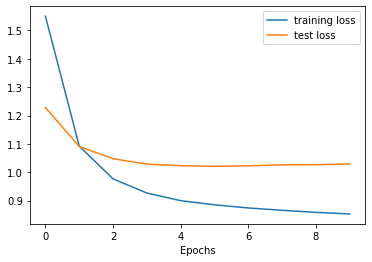

In [315]:
#baseline model
plt.plot(bs_results.history['loss'], label='training loss')
plt.plot(bs_results.history['val_loss'], label='test loss')
plt.xlabel('Epochs')
plt.legend();

In [316]:
#define a function that will go in the scikit=learn wrapper

def model_func(layer_one_neurons=32, layer_two_neurons=16, layer_two=True):
    
    model=Sequential()
    
    #first layer --input and first hidden layer
    model.add(Dense(units=layer_one_neurons, activation='relu', input_shape=(X_train_sc.shape[1],)))

    if layer_two:
        model.add(Dense(units=layer_two_neurons, activation='relu'))

    #add the output layer
    model.add(Dense(5, activation='softmax'))
    
    #compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [317]:
#Instantiate the Keras deep network wrapper
nn=KerasClassifier(build_fn=model_func, epochs=10, batch_size=256, verbose=0)

In [318]:
#param
params={
    'layer_one_neurons':[16,32],
    'layer_two_neurons':[16,32],
    'layer_two':[True, False]
}

In [319]:
#Instatiate a Gridsearch 
gs_nn=GridSearchCV(estimator=nn, param_grid=params, cv=3)
results=gs_nn.fit(X_train_sc, y_train_nn)

In [354]:
#best score on training data
print(f'Training score: {gs_nn.best_score_}')

Training score: 0.6087454756100973


In [355]:
#best score on test data
print(f'Testing score: {gs_nn.score(X_test_sc, y_test_nn)}')

Testing score: 0.6184486150741577


## NN model with one hiden layer has similar performance to baseline model, but model is not overfitted.

In [322]:
#define a function that will go in the scikit=learn wrapper
def model_func_deep(layer_one_neurons=32, next_layer_neurons=16, drop_rate=.5, hidden_layers=5):
    
    model=Sequential()
    
    for layer in range(hidden_layers):
        if layer ==0:
            model.add(Dense(units=layer_one_neurons, activation='relu', input_shape=(X_train_sc.shape[1],)))
            model.add(Dropout(rate=drop_rate))
        else:
            model.add(Dense(units=next_layer_neurons, activation='relu'))
            model.add(Dropout(rate=drop_rate))
            
     #add the output layer
    model.add(Dense(5, activation='softmax'))
    
    #compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [323]:
#Instantiate the Keras deep network wrapper
nn_deep=KerasClassifier(build_fn=model_func_deep, epochs=10, batch_size=256, verbose=0)

In [324]:
#param
params={
    'next_layer_neurons':[16,32],
    'drop_rate':[0.2,0.5],
    'hidden_layers':[2,3,4]
}

In [325]:
#Instatiate a Gridsearch 
gs_nn_deep=GridSearchCV(estimator=nn_deep, param_grid=params, cv=3)
results_deep=gs_nn_deep.fit(X_train_sc, y_train_nn)

In [356]:
#The best score on training data
print(f'Training score: {gs_nn_deep.best_score_}')

Training score: 0.6141867637634277


In [358]:
#Get the best parameters from gridsearch
print(f'Best parameter for nn_deep model: {gs_nn_deep.best_params_}')

Best parameter for nn_deep model: {'drop_rate': 0.2, 'hidden_layers': 2, 'next_layer_neurons': 32}


In [359]:
#Get the score on test dataset
print(f'Testing score: {gs_nn_deep.score(X_test_sc, y_test_nn)}')

Testing score: 0.623390257358551


### NN model with 2 hiden layers and drop rate of 0.2 has higher score than baseline model

In [329]:
nn_deep_pred=gs_nn_deep.predict(X_test_sc)

In [330]:
metrics.confusion_matrix(y_true=y_test, y_pred=nn_deep_pred)

array([[2267,  171,  251,    3,    0],
       [ 721, 1414,  208,    9,    0],
       [ 551,  168,  473,    5,    0],
       [  58,  211,  110,    9,    0],
       [   3,   43,    3,    0,    0]], dtype=int64)

In [ ]:
deep_pred =to_categorial(nn_deep_pred)

## Model conclusion

- NN deeplearning with 2 hidden layers and drop_rate of 0.2 has the best performance and also outperform the baseline model.

## Load test.csv data

In [235]:
test=pd.read_csv('datasets/test.csv', header=0)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11456 entries, 0 to 11455
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              11456 non-null  int64 
 1   Name            8231 non-null   object
 2   DateTime        11456 non-null  object
 3   AnimalType      11456 non-null  object
 4   SexuponOutcome  11456 non-null  object
 5   AgeuponOutcome  11450 non-null  object
 6   Breed           11456 non-null  object
 7   Color           11456 non-null  object
dtypes: int64(1), object(7)
memory usage: 716.1+ KB


In [236]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


## EDA and make the features the same so it can be used for model fit

In [237]:
test_1=pd.get_dummies(data=test, columns=['AnimalType','SexuponOutcome','Breed','Color'], drop_first=True)

In [238]:
test_1['DateTime'] = pd.to_datetime(test_1['DateTime'])

In [239]:
#save the years of the datetime into date_year column
test_1['Date_year'] = pd.DatetimeIndex(test_1['DateTime']).year

In [240]:
#save the years of the datetime into date_year column
test_1['Date_month'] = pd.DatetimeIndex(test_1['DateTime']).month

In [241]:
test_1.drop(columns=['DateTime'], inplace=True)
test_1.head()

,ID,Name,AgeuponOutcome,AnimalType_Dog,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,Breed_Airedale Terrier Mix,Breed_Airedale Terrier/Irish Terrier,...,Color_White/White,Color_White/Yellow Brindle,Color_Yellow,Color_Yellow Brindle,Color_Yellow Brindle/White,Color_Yellow/Gray,Color_Yellow/Tan,Color_Yellow/White,Date_year,Date_month
0,1,Summer,10 months,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2015,10
1,2,Cheyenne,2 years,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2014,7
2,3,Gus,1 year,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2016,1
3,4,Pongo,4 months,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2013,12
4,5,Skooter,2 years,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2015,9


In [242]:
#check how many null value in Age column
test_1['AgeuponOutcome'].isnull().sum()

6

In [243]:
#fill the na with 0 year
test_1['AgeuponOutcome'].fillna('0 year', inplace=True)

In [244]:
#split the str by whitespace into a list
test_1['AgeuponOutcome'] = test_1['AgeuponOutcome'].str.split(' ')

In [245]:
#get separate columns
test_df=pd.DataFrame(test_1['AgeuponOutcome'].to_list(), columns=['num', 'units'], index=test_1.index)

In [247]:
#Add the splitted columns to the original data frame
test_1=pd.concat([test_1, test_df], axis=1)

#drop the original AgeuponOutcome column
test_1.drop(columns=['AgeuponOutcome'], inplace=True)

In [248]:
#convert the 'num' datatype into integer
test_1['num'] = test_1['num'].astype(int)

#reset index
test_1.reset_index(inplace=True)

#get a list of age in weeks based on units of age

#initialize an empty list
age=[]

#loop through the dataframe
for i in range(len(test_1)):
    # if the age units is in year or years, times 52.143 to convert the num in years into weeks
    if test_1['units'][i] in ['year','years']:
        age.append(test_1['num'][i]*52.143 )
    # if the age units is in month or months, times 4.345 to convert the num in months into weeks
    elif test_1['units'][i] in ['month','months']:
        age.append(test_1['num'][i]*4.345 )
    # if the age units is in day or days, times .143 to convert the num in days into weeks
    elif test_1['units'][i] in ['day','days']:
        age.append(test_1['num'][i]*.143)
    #else, just append the original
    else:
        age.append(test_1['num'][i])

#create a column of age in weeks
test_1['age_in_weeks']=age

#drop the num and units columns
test_1.drop(columns=['num','units'], inplace=True)

In [249]:
test_1.head()

,index,ID,Name,AnimalType_Dog,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,Breed_Airedale Terrier Mix,Breed_Airedale Terrier/Irish Terrier,...,Color_White/Yellow Brindle,Color_Yellow,Color_Yellow Brindle,Color_Yellow Brindle/White,Color_Yellow/Gray,Color_Yellow/Tan,Color_Yellow/White,Date_year,Date_month,age_in_weeks
0,0,1,Summer,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2015,10,43.450
1,1,2,Cheyenne,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2014,7,104.286
2,2,3,Gus,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2016,1,52.143
3,3,4,Pongo,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2013,12,17.380
4,4,5,Skooter,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2015,9,104.286


## Create features for model

In [252]:
features=X.columns
len(features)

1753

In [253]:
X_ts=test_1.drop(columns=['index', 'ID','Name'])
X_ts

,AnimalType_Dog,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,Breed_Airedale Terrier Mix,Breed_Airedale Terrier/Irish Terrier,Breed_Akita,Breed_Akita Mix,Breed_Akita/Border Collie,...,Color_White/Yellow Brindle,Color_Yellow,Color_Yellow Brindle,Color_Yellow Brindle/White,Color_Yellow/Gray,Color_Yellow/Tan,Color_Yellow/White,Date_year,Date_month,age_in_weeks
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2015,10,43.450
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014,7,104.286
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2016,1,52.143
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2013,12,17.380
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2015,9,104.286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11451,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014,7,8.690
11452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014,10,2.000
11453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014,9,52.143
11454,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2015,9,312.858


In [332]:
#get the common features in both train.csv and test.csv
features=[item for item in X.columns if item in X_ts.columns]
features[:5]

['Date_year',
 'Date_month',
 'age_in_weeks',
 'SexuponOutcome_Intact Male',
 'SexuponOutcome_Neutered Male']

In [333]:
#create X features
X_ts=X_ts[features]

## Make a prediction

In [351]:
#make prediction using nn_deep model
pred=gs_nn_deep.predict(X_ts)
pred

array([2, 2, 2, ..., 2, 2, 2])

In [337]:
#convert the prediction to 5 classes
pred_array=to_categorical(pred, num_classes=5)
pred_array[:5]

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [361]:
#create the prediction dataframe
pred_df=pd.DataFrame(pred_array, columns=['Adoption','Transfer','Return_to_owner','Euthanasia','Died']).astype(int)
pred_df['ID']=test_1['ID']
pred_df=pred_df[['ID','Adoption','Transfer','Return_to_owner','Euthanasia','Died']]
pred_df.head()

,ID,Adoption,Transfer,Return_to_owner,Euthanasia,Died
0,1,0,0,1,0,0
1,2,0,0,1,0,0
2,3,0,0,1,0,0
3,4,0,0,1,0,0
4,5,0,0,1,0,0


In [362]:
#check the stats of the prediction outcome
pred_df.drop(columns='ID').value_counts(normalize=True)

Adoption  Transfer  Return_to_owner  Euthanasia  Died
0         0         1                0           0       0.982716
1         0         0                0           0       0.017284
dtype: float64

In [363]:
#save prediction to csv
pred_df.to_csv('datasets/submission.csv', index=0)

### Model Summary
- Random Forest classifier Gridsearch is not as efficient as NN models (computing time is likely 3 times longer)
- NN models with 1 hidden layers has similar accuracy score as baseline model
- NN model with 2 hidden layers and 2 drop out layers (with drop_rate of 0.2) has the best performance 

|Model|Accuracy on train|Accuracy on test|
|---|---|---|
|RFC|0.97|0.61|
|NN|0.61|0.618|
|NN_deep|0.61|0.623|

## Conclusion:
- The model predicts the outcomes of animals mostly to the majority classes (such as `Adoption` and `Return_to_owner`) and not able to predict `Died` and `Entuanasia` likely due to the unbalanced population in the training set.